In [104]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

In [105]:
# base for the autoencoder

class Autoencoder(nn.Module):
    def __init__(self, input_size = 4, output_size = 1):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_size, 16),
            nn.ReLU(),
            nn.Linear(16, 8),
            nn.ReLU(),
            nn.Linear(8, 6),
            nn.ReLU(),
            nn.Linear(6, 3)
        )

        self.decoder = nn.Sequential(
            nn.Linear(3, 6),
            nn.ReLU(),
            nn.Linear(6, 8),
            nn.ReLU(),
            nn.Linear(8, 16),
            nn.ReLU(),
            nn.Linear(16, output_size)
        )

    def forward(self, input):
        encoded = self.encoder(input)
        decoded = self.decoder(encoded)
        return decoded

In [106]:
# reading data

myDF = pd.read_excel("Copy of Folds5x2_pp.xlsx")
cleanDF = myDF.fillna(0)

In [107]:
# assigning columns

output_column = cleanDF.columns[-1]
input_columns = [col for col in cleanDF.columns if col != output_column]

print("Input columns:", input_columns)
print("Output column:", output_column)

Input columns: ['AT', 'V', 'AP', 'RH']
Output column: PE


In [108]:
# extracting data from columns

input_data = cleanDF[input_columns].values
output_data = cleanDF[output_column].values

print(f"Input shape: {input_data.shape}, Output shape: {output_data.shape}")
print(f"\nFirst 5 rows of real data:")
print(cleanDF[input_columns + [output_column]].head())

Input shape: (9568, 4), Output shape: (9568,)

First 5 rows of real data:
      AT      V       AP     RH      PE
0  14.96  41.76  1024.07  73.17  463.26
1  25.18  62.96  1020.04  59.08  444.37
2   5.11  39.40  1012.16  92.14  488.56
3  20.86  57.32  1010.24  76.64  446.48
4  10.82  37.50  1009.23  96.62  473.90


In [109]:
# normalizing data

input_scaler = StandardScaler()
output_scaler = StandardScaler()

scalar_input = input_scaler.fit_transform(input_data)
scalar_output = output_scaler.fit_transform(output_data.reshape(-1, 1)).flatten()

print("Scalers saved for cross-sheet testing!")

print(f"Original data range:")
for i, col in enumerate(input_columns):
    print(f"{col}: {input_data[:, i].min():.2f} to {input_data[:, i].max():.2f}")
print(f"{output_column}: {output_data.min():.2f} to {output_data.max():.2f}")

print(f"\nNormalized data range:")
for i, col in enumerate(input_columns):
    print(f"{col}: {scalar_input[:, i].min():.2f} to {scalar_input[:, i].max():.2f}")
print(f"{output_column}: {scalar_output.min():.2f} to {scalar_output.max():.2f}")

print(f"\nNormalized input shape: {scalar_input.shape}, Normalized output shape: {scalar_output.shape}")

Scalers saved for cross-sheet testing!
Original data range:
AT: 1.81 to 37.11
V: 25.36 to 81.56
AP: 992.89 to 1033.30
RH: 25.56 to 100.16
PE: 420.26 to 495.76

Normalized data range:
AT: -2.39 to 2.34
V: -2.28 to 2.14
AP: -3.43 to 3.37
RH: -3.27 to 1.84
PE: -2.00 to 2.43

Normalized input shape: (9568, 4), Normalized output shape: (9568,)


In [110]:
# splitting data into training and testing sets

input_train, input_test, output_train, output_test = train_test_split(
    scalar_input, scalar_output, test_size=0.2, random_state=42
)
# test_size = 0.2 => 20% data for testing, rest for training

input_train_tensor = torch.FloatTensor(input_train)
input_test_tensor = torch.FloatTensor(input_test)
output_train_tensor = torch.FloatTensor(output_train).unsqueeze(1)
output_test_tensor = torch.FloatTensor(output_test).unsqueeze(1)

model = Autoencoder(input_size=4, output_size=1)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [111]:
# training

no_of_epochs = 500
train_losses = []

for epoch in range(no_of_epochs):
    model.train()
    optimizer.zero_grad()
    
    predictions = model(input_train_tensor)
    
    loss = criterion(predictions, output_train_tensor)
    
    loss.backward()
    optimizer.step()
    
    train_losses.append(loss.item())
    
    if ((epoch + 1) % (no_of_epochs / 10)) == 0:
        print(f'Epoch [{epoch + 1}/{no_of_epochs}], Loss: {loss.item():.4f}')

print(f"\nTraining completed")
print(f"Final training loss: {train_losses[-1]:.4f}")

Epoch [50/500], Loss: 1.0084
Epoch [100/500], Loss: 0.8335
Epoch [100/500], Loss: 0.8335
Epoch [150/500], Loss: 0.2289
Epoch [200/500], Loss: 0.0890
Epoch [150/500], Loss: 0.2289
Epoch [200/500], Loss: 0.0890
Epoch [250/500], Loss: 0.0723
Epoch [300/500], Loss: 0.0656
Epoch [250/500], Loss: 0.0723
Epoch [300/500], Loss: 0.0656
Epoch [350/500], Loss: 0.0628
Epoch [400/500], Loss: 0.0617
Epoch [350/500], Loss: 0.0628
Epoch [400/500], Loss: 0.0617
Epoch [450/500], Loss: 0.0610
Epoch [450/500], Loss: 0.0610
Epoch [500/500], Loss: 0.0605

Training completed
Final training loss: 0.0605
Epoch [500/500], Loss: 0.0605

Training completed
Final training loss: 0.0605


In [112]:
# testing

model.eval()
with torch.no_grad():
    test_predictions = model(input_test_tensor)
    test_loss = criterion(test_predictions, output_test_tensor)

print(f"Test Loss on Real Data: {test_loss.item():.4f}")

test_predictions_numpy = test_predictions.numpy().flatten()
output_test_numpy = output_test_tensor.numpy().flatten()

mse = np.mean((test_predictions_numpy - output_test_numpy) ** 2)
mae = np.mean(np.abs(test_predictions_numpy - output_test_numpy))
rmse = np.sqrt(mse)

print(f"\nTest Metrics on Real Data:")
print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")

print(f"\nSample Predictions vs Actual on Real Data:")
for i in range(10):
    print(f"Sample {i+1}: Predicted={test_predictions_numpy[i]:.3f}, Actual={output_test_numpy[i]:.3f}")

Test Loss on Real Data: 0.0583

Test Metrics on Real Data:
Mean Squared Error (MSE): 0.0583
Mean Absolute Error (MAE): 0.1884
Root Mean Squared Error (RMSE): 0.2414

Sample Predictions vs Actual on Real Data:
Sample 1: Predicted=0.047, Actual=0.053
Sample 2: Predicted=-0.941, Actual=-1.058
Sample 3: Predicted=-1.169, Actual=-0.802
Sample 4: Predicted=-0.920, Actual=-1.170
Sample 5: Predicted=1.532, Actual=1.623
Sample 6: Predicted=-0.941, Actual=-1.072
Sample 7: Predicted=-0.367, Actual=-0.110
Sample 8: Predicted=-1.131, Actual=-1.122
Sample 9: Predicted=-1.220, Actual=-1.256
Sample 10: Predicted=1.127, Actual=0.709


In [113]:
# now testing on other sheets
all_sheets = pd.read_excel("Copy of Folds5x2_pp.xlsx", sheet_name=None)
sheet_names = list(all_sheets.keys())
trainer = sheet_names[0]
tester = sheet_names[1:]

In [114]:
# testing function

def testing_sheets(model, sheet_data,
                   sheet_name, input_columns, output_column,
                   input_scaler, output_scaler, criterion):
    print(f"\nTesting on sheet: {sheet_name}")
    clean_sheet = sheet_data.fillna(0)

    sheet_input = clean_sheet[input_columns].values
    sheet_output = clean_sheet[output_column].values

    sheet_input_scaled = input_scaler.transform(sheet_input)
    sheet_output_scaled = output_scaler.transform(sheet_output.reshape(-1, 1)).flatten()

    sheet_input_tensor = torch.FloatTensor(sheet_input_scaled)
    sheet_output_tensor = torch.FloatTensor(sheet_output_scaled).unsqueeze(1)

    model.eval()
    with torch.no_grad():
        predictions = model(sheet_input_tensor)
        loss = criterion(predictions, sheet_output_tensor.unsqueeze(1))

    predictions_numpy = predictions.numpy().flatten()
    output_numpy = sheet_output_tensor.numpy().flatten()

    mse = np.mean((predictions_numpy - output_numpy) ** 2)
    mae = np.mean(np.abs(predictions_numpy - output_numpy))
    rmse = np.sqrt(mse)

    print(f"Test Loss on {sheet_name}: {loss.item():.4f}, MSE: {mse:.4f}, MAE: {mae:.4f}, RMSE: {rmse:.4f}")

    return {
        'sheet_name' : sheet_name,
        'loss' : loss.item(),
        'mse' : mse,
        'mae' : mae,
        'rmse' : rmse,
        'predictions' : predictions_numpy,
        'actuals' : output_numpy
    }

In [115]:
results = []

for sheet_name in tester:
    sheet_data = all_sheets[sheet_name]
    result = testing_sheets(model, sheet_data, sheet_name,
                            input_columns, output_column,
                            input_scaler, output_scaler, criterion)
    results.append(result)


Testing on sheet: Sheet2
Test Loss on Sheet2: 1.9426, MSE: 0.0601, MAE: 0.1900, RMSE: 0.2451

Testing on sheet: Sheet3
Test Loss on Sheet3: 1.9426, MSE: 0.0601, MAE: 0.1900, RMSE: 0.2451

Testing on sheet: Sheet4
Test Loss on Sheet4: 1.9426, MSE: 0.0601, MAE: 0.1900, RMSE: 0.2451

Testing on sheet: Sheet5
Test Loss on Sheet5: 1.9426, MSE: 0.0601, MAE: 0.1900, RMSE: 0.2451


c:\Users\AERAN\Desktop\vestas-internship\.venv\Lib\site-packages\torch\nn\modules\loss.py:610: UserWarning: Using a target size (torch.Size([9568, 1, 1])) that is different to the input size (torch.Size([9568, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
c:\Users\AERAN\Desktop\vestas-internship\.venv\Lib\site-packages\torch\nn\modules\loss.py:610: UserWarning: Using a target size (torch.Size([9568, 1, 1])) that is different to the input size (torch.Size([9568, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
c:\Users\AERAN\Desktop\vestas-internship\.venv\Lib\site-packages\torch\nn\modules\loss.py:610: UserWarning: Using a target size (torch.Size([9568, 1, 1])) that is different to the input size (torch.Size([9568, 1])). This will likely lead to

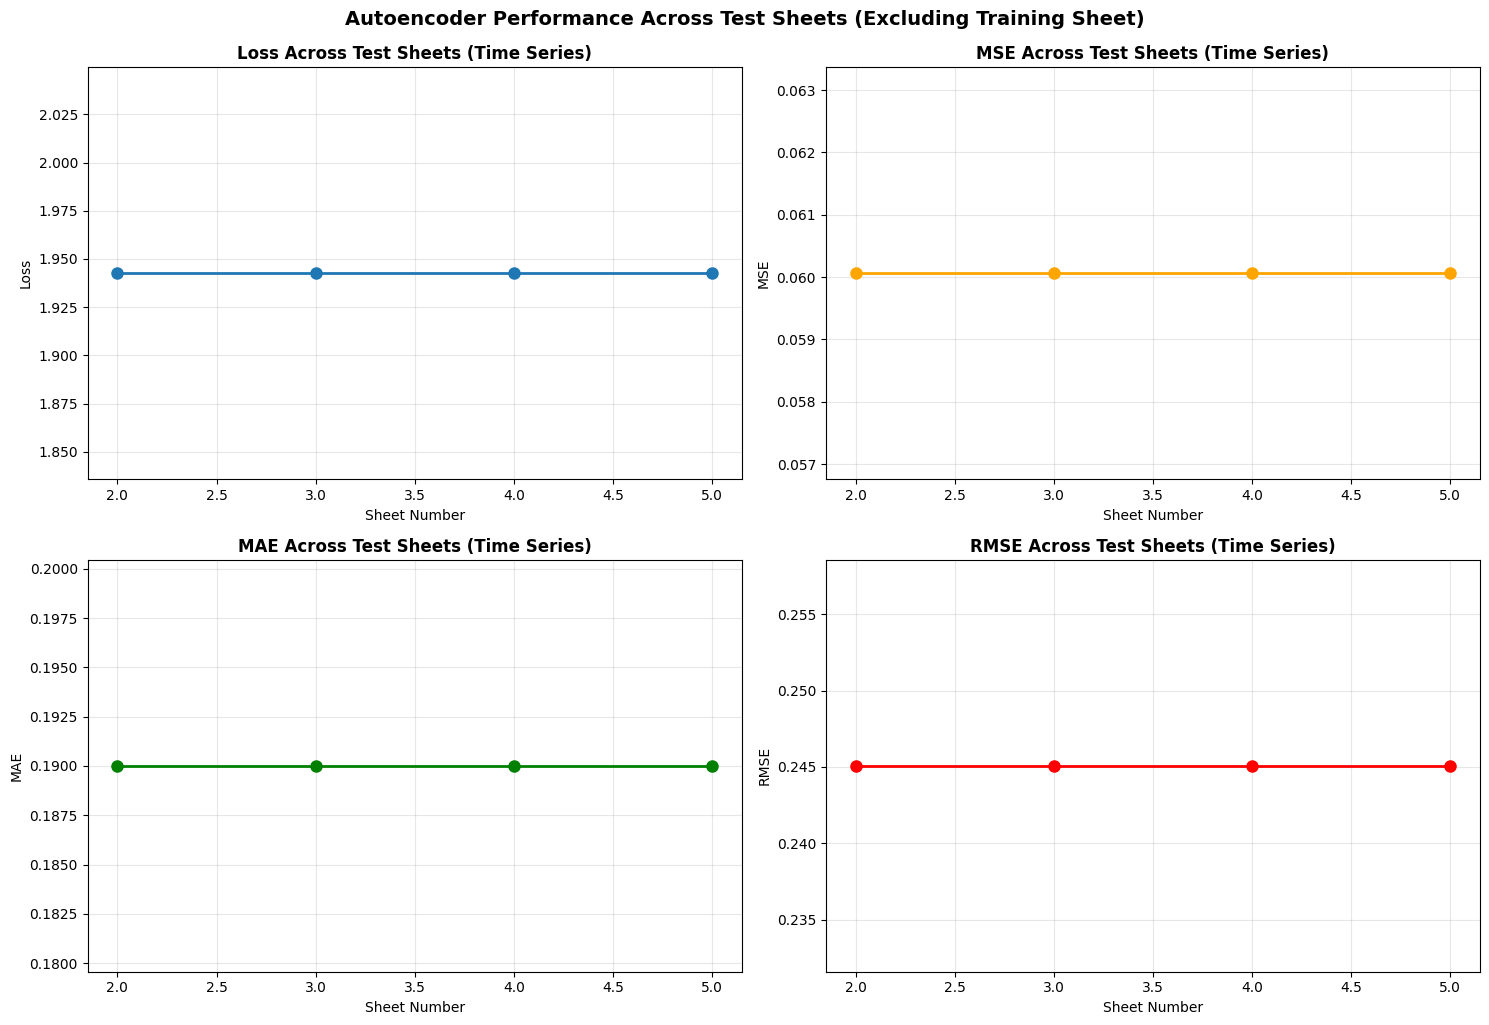

In [116]:
# Creating time series visualization
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Extracting data for plotting
sheet_names = [r['sheet_name'] for r in results]
sheet_numbers = range(2, len(results) + 2)  # Start from 2 since we skipped sheet 1

# Time series plots
axes[0,0].plot(sheet_numbers, [r['loss'] for r in results], 'o-', linewidth=2, markersize=8)
axes[0,0].set_title('Loss Across Test Sheets (Time Series)', fontsize=12, fontweight='bold')
axes[0,0].set_xlabel('Sheet Number')
axes[0,0].set_ylabel('Loss')
axes[0,0].grid(True, alpha=0.3)

axes[0,1].plot(sheet_numbers, [r['mse'] for r in results], 'o-', color='orange', linewidth=2, markersize=8)
axes[0,1].set_title('MSE Across Test Sheets (Time Series)', fontsize=12, fontweight='bold')
axes[0,1].set_xlabel('Sheet Number')
axes[0,1].set_ylabel('MSE')
axes[0,1].grid(True, alpha=0.3)

axes[1,0].plot(sheet_numbers, [r['mae'] for r in results], 'o-', color='green', linewidth=2, markersize=8)
axes[1,0].set_title('MAE Across Test Sheets (Time Series)', fontsize=12, fontweight='bold')
axes[1,0].set_xlabel('Sheet Number')
axes[1,0].set_ylabel('MAE')
axes[1,0].grid(True, alpha=0.3)

axes[1,1].plot(sheet_numbers, [r['rmse'] for r in results], 'o-', color='red', linewidth=2, markersize=8)
axes[1,1].set_title('RMSE Across Test Sheets (Time Series)', fontsize=12, fontweight='bold')
axes[1,1].set_xlabel('Sheet Number')
axes[1,1].set_ylabel('RMSE')
axes[1,1].grid(True, alpha=0.3)

plt.tight_layout()
plt.suptitle('Autoencoder Performance Across Test Sheets (Excluding Training Sheet)', 
             fontsize=14, fontweight='bold', y=1.02)
plt.show()

In [117]:
# Creating summary table
results_df = pd.DataFrame([{
    'Sheet_Number': i + 2,  # Start from 2 since we skipped sheet 1
    'Sheet_Name': r['sheet_name'],
    'Loss': r['loss'],
    'MSE': r['mse'],
    'MAE': r['mae'],
    'RMSE': r['rmse']
} for i, r in enumerate(results)])

print("\n=== PERFORMANCE SUMMARY (EXCLUDING TRAINING SHEET) ===")
print(results_df.round(4))

# Finding best and worst performing sheets
if len(results_df) > 0:
    best_loss_idx = results_df['Loss'].idxmin()
    worst_loss_idx = results_df['Loss'].idxmax()
    
    print(f"\nBest performing sheet: {results_df.loc[best_loss_idx, 'Sheet_Name']} (Loss: {results_df.loc[best_loss_idx, 'Loss']:.4f})")
    print(f"Worst performing sheet: {results_df.loc[worst_loss_idx, 'Sheet_Name']} (Loss: {results_df.loc[worst_loss_idx, 'Loss']:.4f})")


=== PERFORMANCE SUMMARY (EXCLUDING TRAINING SHEET) ===
   Sheet_Number Sheet_Name    Loss     MSE   MAE    RMSE
0             2     Sheet2  1.9426  0.0601  0.19  0.2451
1             3     Sheet3  1.9426  0.0601  0.19  0.2451
2             4     Sheet4  1.9426  0.0601  0.19  0.2451
3             5     Sheet5  1.9426  0.0601  0.19  0.2451

Best performing sheet: Sheet2 (Loss: 1.9426)
Worst performing sheet: Sheet2 (Loss: 1.9426)


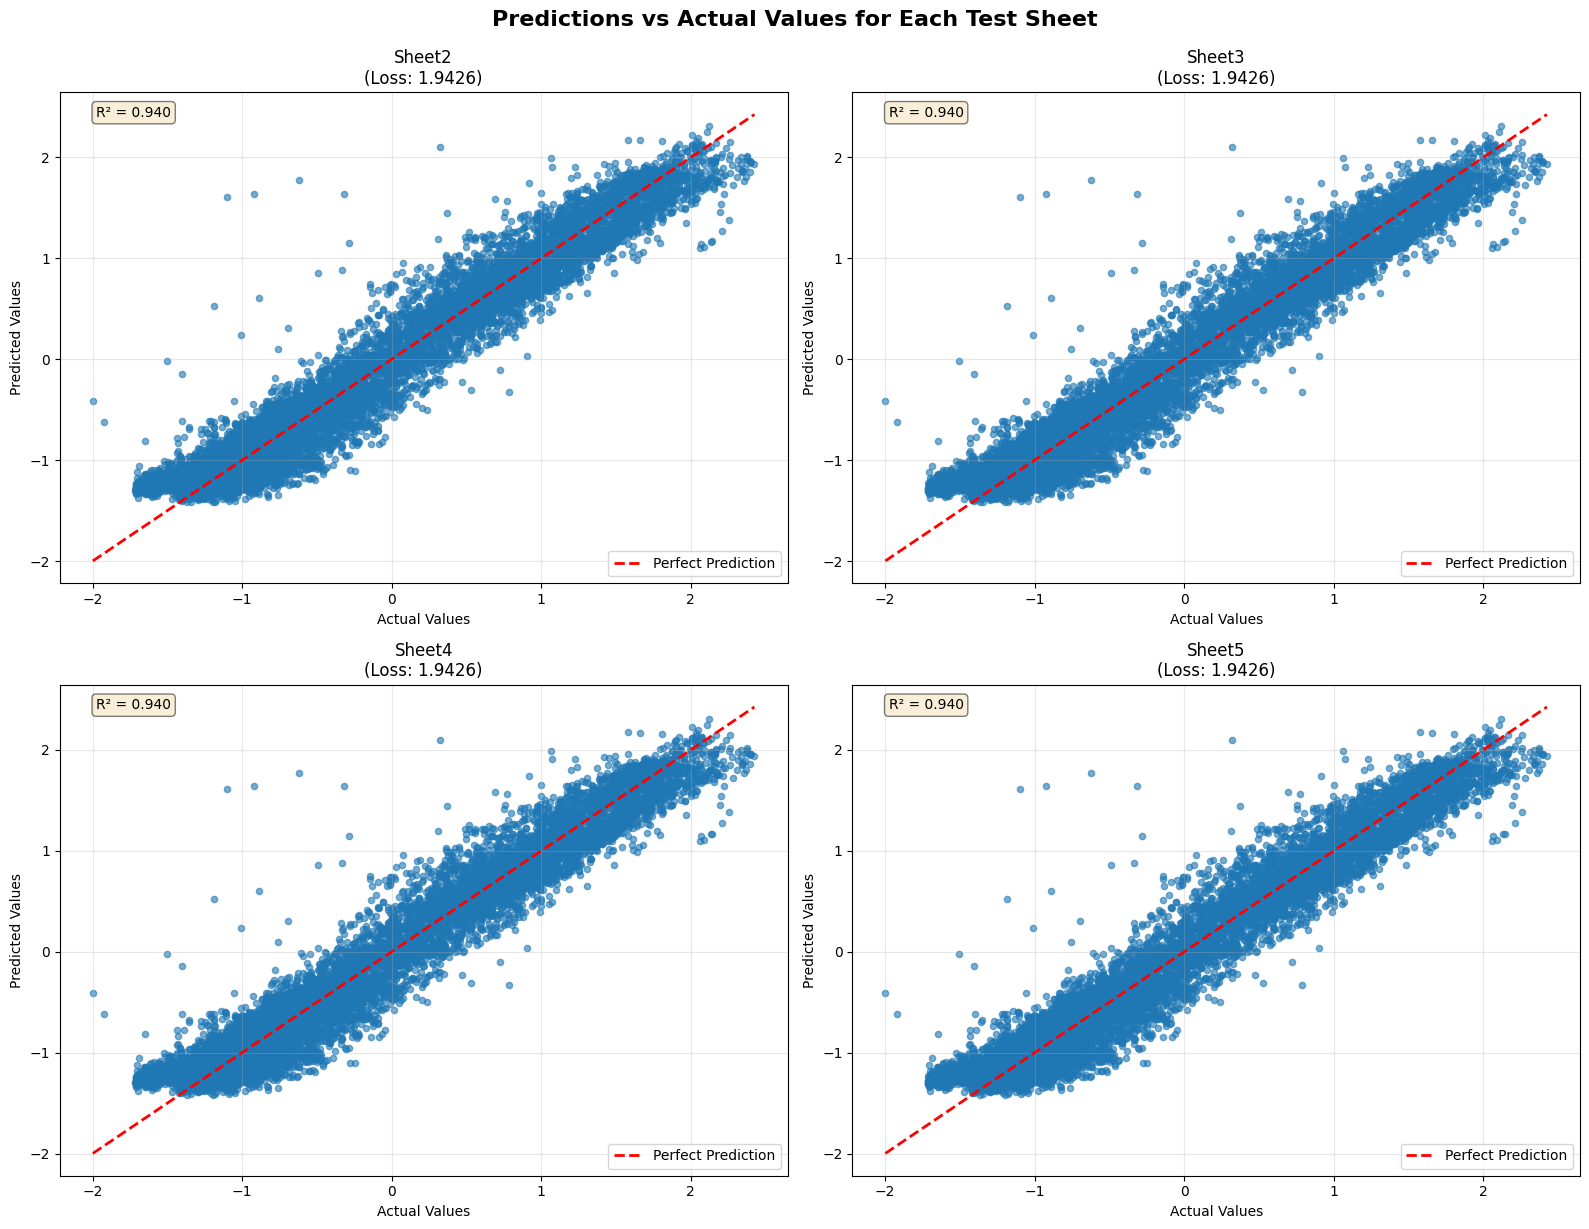

In [118]:
# Prediction vs Actual scatter plots for each test sheet
n_sheets = len(results)
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
axes = axes.flatten()

for i, result in enumerate(results):
    if i < 4:
        ax = axes[i]
        
        predictions = result['predictions']
        actuals = result['actuals']
        
        # Scatter plot
        ax.scatter(actuals, predictions, alpha=0.6, s=20)
        
        # Perfect prediction line (diagonal)
        min_val = min(actuals.min(), predictions.min())
        max_val = max(actuals.max(), predictions.max())
        ax.plot([min_val, max_val], [min_val, max_val], 'r--', linewidth=2, label='Perfect Prediction')
        
        ax.set_xlabel('Actual Values')
        ax.set_ylabel('Predicted Values')
        ax.set_title(f'{result["sheet_name"]}\n(Loss: {result["loss"]:.4f})')
        ax.legend()
        ax.grid(True, alpha=0.3)
        
        # Calculate R²
        correlation = np.corrcoef(actuals, predictions)[0, 1]
        r_squared = correlation ** 2
        ax.text(0.05, 0.95, f'R² = {r_squared:.3f}', transform=ax.transAxes, 
                bbox=dict(boxstyle="round", facecolor='wheat', alpha=0.5))

# Hide empty subplots if less than 4 sheets
for i in range(len(results), 4):
    axes[i].set_visible(False)

plt.tight_layout()
plt.suptitle('Predictions vs Actual Values for Each Test Sheet', fontsize=16, fontweight='bold', y=1.02)
plt.show()

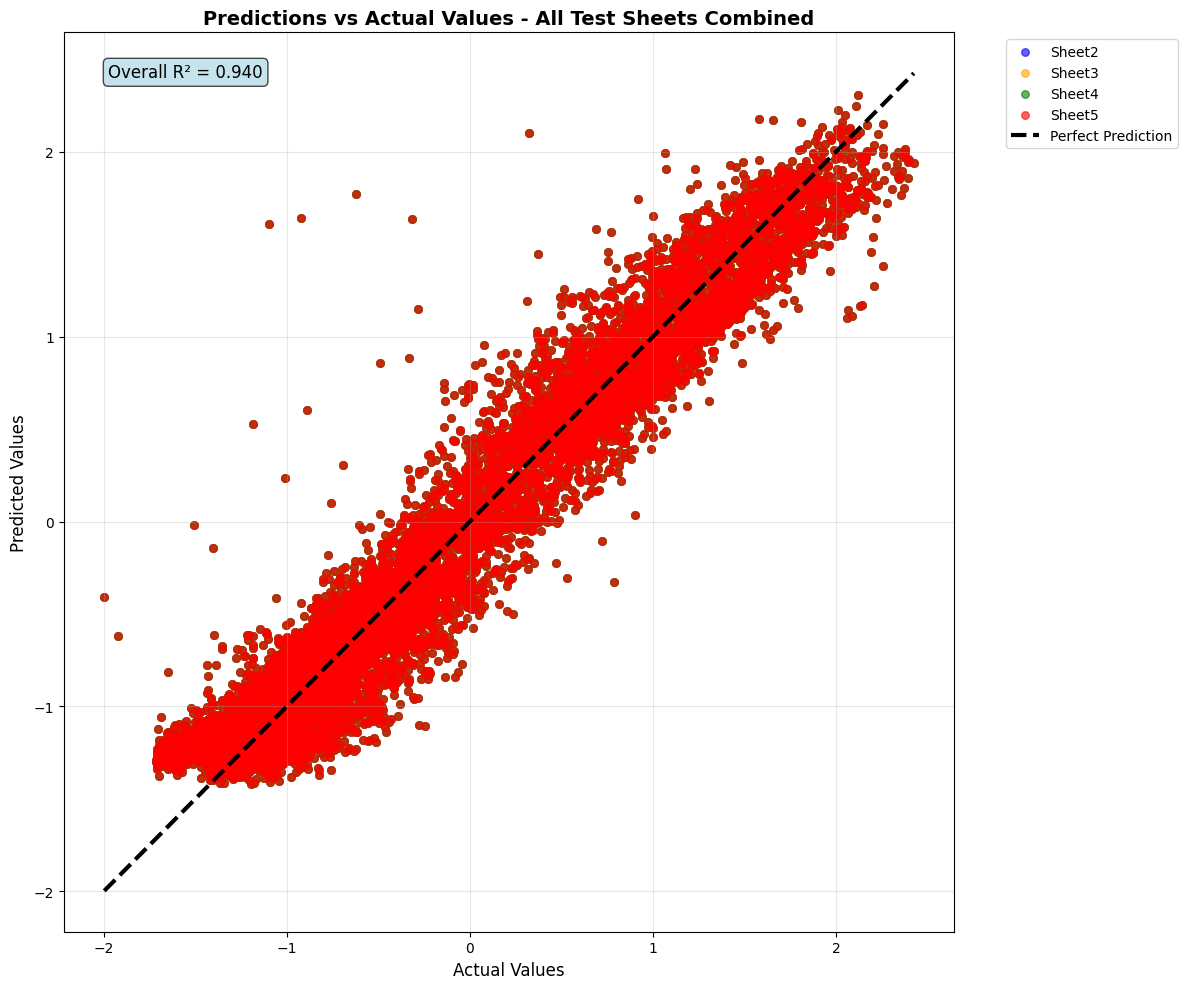

In [119]:
# Combined prediction vs actual plot for all test sheets
plt.figure(figsize=(12, 10))

colors = ['blue', 'orange', 'green', 'red', 'purple', 'brown', 'pink', 'gray']

for i, result in enumerate(results):
    predictions = result['predictions']
    actuals = result['actuals']
    
    plt.scatter(actuals, predictions, alpha=0.6, s=30, 
                color=colors[i % len(colors)], label=f'{result["sheet_name"]}')

# Perfect prediction line
all_actuals = np.concatenate([r['actuals'] for r in results])
all_predictions = np.concatenate([r['predictions'] for r in results])

min_val = min(all_actuals.min(), all_predictions.min())
max_val = max(all_actuals.max(), all_predictions.max())
plt.plot([min_val, max_val], [min_val, max_val], 'k--', linewidth=3, label='Perfect Prediction')

plt.xlabel('Actual Values', fontsize=12)
plt.ylabel('Predicted Values', fontsize=12)
plt.title('Predictions vs Actual Values - All Test Sheets Combined', fontsize=14, fontweight='bold')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, alpha=0.3)

# Overall R²
overall_r_squared = np.corrcoef(all_actuals, all_predictions)[0, 1] ** 2
plt.text(0.05, 0.95, f'Overall R² = {overall_r_squared:.3f}', transform=plt.gca().transAxes, 
         bbox=dict(boxstyle="round", facecolor='lightblue', alpha=0.7), fontsize=12)

plt.tight_layout()
plt.show()

In [120]:
# Load all sheets for combined training
all_sheets = pd.read_excel("Copy of Folds5x2_pp.xlsx", sheet_name=None)
sheet_names = list(all_sheets.keys())

In [121]:
# Combine all sheets into a single DataFrame
combined_sheets = []
for sheet in all_sheets.items():
    combined_sheets.append(sheet[1].fillna(0))

# Combine all sheets into a single DataFrame
combined_data = pd.concat(combined_sheets, ignore_index=True)
print(f"Combined data shape: {combined_data.shape}")
print(f"Columns: {combined_data.columns.tolist()}")

Combined data shape: (47840, 5)
Columns: ['AT', 'V', 'AP', 'RH', 'PE']


In [122]:
combined_normalized = StandardScaler().fit_transform(combined_data)
combined_normalized = pd.DataFrame(combined_normalized, columns=combined_data.columns)
print(f"Normalized data shape: {combined_normalized.shape}")
print(f"Sample statistics after normalization:")
print(combined_normalized.describe())

Normalized data shape: (47840, 5)
Sample statistics after normalization:
                 AT             V            AP            RH            PE
count  4.784000e+04  4.784000e+04  4.784000e+04  4.784000e+04  4.784000e+04
mean  -1.815716e-16 -7.510900e-16  5.473437e-15 -3.366315e-16  4.887506e-15
std    1.000010e+00  1.000010e+00  1.000010e+00  1.000010e+00  1.000010e+00
min   -2.394126e+00 -2.277901e+00 -3.430019e+00 -3.270589e+00 -1.998406e+00
25%   -8.240958e-01 -9.888705e-01 -7.003615e-01 -6.836860e-01 -8.563765e-01
50%    9.309729e-02 -1.751604e-01 -5.373067e-02  1.141150e-01 -1.649474e-01
75%    8.143721e-01  9.627745e-01  6.737290e-01  7.891378e-01  8.241478e-01
max    2.342804e+00  2.144779e+00  3.374760e+00  1.839173e+00  2.425568e+00


In [123]:
combined_input_columns = [col for col in combined_data.columns if col != 'PE']
combined_output_column = 'PE'

combined_input_data = combined_normalized[combined_input_columns].values
combined_output_data = combined_normalized[combined_output_column].values

combined_input_train, combined_input_test, combined_output_train, combined_output_test = train_test_split(
    combined_input_data, combined_output_data, test_size=0.2, random_state=42
)

combined_input_train_tensor = torch.FloatTensor(combined_input_train)
combined_input_test_tensor = torch.FloatTensor(combined_input_test)
combined_output_train_tensor = torch.FloatTensor(combined_output_train).unsqueeze(1)
combined_output_test_tensor = torch.FloatTensor(combined_output_test).unsqueeze(1)


model = Autoencoder(input_size=4, output_size=1)
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [124]:
# Training loop
epochs = 500
combined_losses = []

for epoch in range(epochs):
    model.train()
    optimizer.zero_grad()
    
    # Forward pass
    predictions = model(combined_input_train_tensor)
    loss = criterion(predictions, combined_output_train_tensor)
    
    # Backward pass
    loss.backward()
    optimizer.step()
    
    combined_losses.append(loss.item())
    
    if (epoch + 1) % 50 == 0:
        print(f'Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.6f}')

print(f"\nCombined training completed!")
print(f"Final training loss: {combined_losses[-1]:.6f}")

Epoch [50/500], Loss: 0.997385
Epoch [100/500], Loss: 0.821786
Epoch [100/500], Loss: 0.821786
Epoch [150/500], Loss: 0.328741
Epoch [150/500], Loss: 0.328741
Epoch [200/500], Loss: 0.200302
Epoch [200/500], Loss: 0.200302
Epoch [250/500], Loss: 0.127873
Epoch [250/500], Loss: 0.127873
Epoch [300/500], Loss: 0.087522
Epoch [300/500], Loss: 0.087522
Epoch [350/500], Loss: 0.069181
Epoch [350/500], Loss: 0.069181
Epoch [400/500], Loss: 0.062352
Epoch [400/500], Loss: 0.062352
Epoch [450/500], Loss: 0.059777
Epoch [450/500], Loss: 0.059777
Epoch [500/500], Loss: 0.058542

Combined training completed!
Final training loss: 0.058542
Epoch [500/500], Loss: 0.058542

Combined training completed!
Final training loss: 0.058542


Test Loss on Combined Data: 0.057685


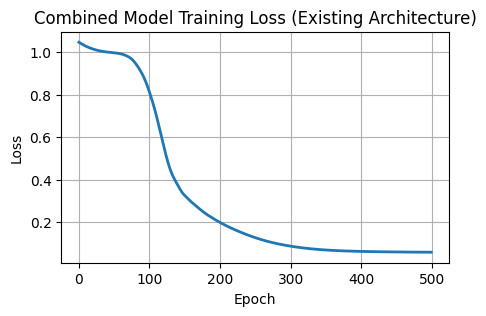

In [125]:
# Testing the model on combined data
model.eval()
with torch.no_grad():
    combined_test_predictions = model(combined_input_test_tensor)
    combined_test_loss = criterion(combined_test_predictions, combined_output_test_tensor)
    print(f"Test Loss on Combined Data: {combined_test_loss.item():.6f}")


plt.figure(figsize=(5, 3))
plt.plot(combined_losses, linewidth=2)
plt.title('Combined Model Training Loss (Existing Architecture)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.show()

Test Loss: 0.0577
Mean Squared Error (MSE): 0.0577
Mean Absolute Error (MAE): 0.1879
Root Mean Squared Error (RMSE): 0.2402
R² Score: 0.9423

Sample Predictions vs Actual (Combined Test Data):
Sample 1: Predicted=-1.2461, Actual=-1.4640
Sample 2: Predicted=0.8354, Actual=1.1482
Sample 3: Predicted=-0.8684, Actual=-1.0369
Sample 4: Predicted=0.3451, Actual=0.6607
Sample 5: Predicted=-0.3865, Actual=-0.7087
Sample 6: Predicted=-0.7610, Actual=-0.7949
Sample 7: Predicted=-0.9917, Actual=-0.7058
Sample 8: Predicted=0.2374, Actual=0.2681
Sample 9: Predicted=1.7518, Actual=2.2181
Sample 10: Predicted=-0.4822, Actual=-0.6138


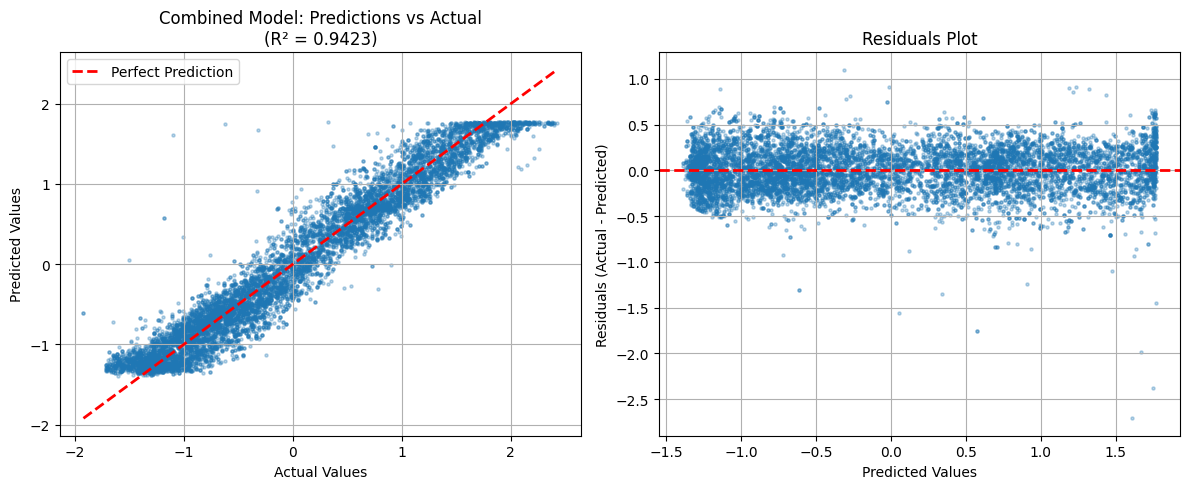


Combined model test complete! Trained on 38272 samples, tested on 9568 samples.


In [126]:
combined_test_predictions_numpy = combined_test_predictions.numpy().flatten()
combined_output_test_numpy = combined_output_test_tensor.numpy().flatten()

combined_mse = np.mean((combined_test_predictions_numpy - combined_output_test_numpy) ** 2)
combined_mae = np.mean(np.abs(combined_test_predictions_numpy - combined_output_test_numpy))
combined_rmse = np.sqrt(combined_mse)

print(f"Test Loss: {combined_test_loss.item():.4f}")
print(f"Mean Squared Error (MSE): {combined_mse:.4f}")
print(f"Mean Absolute Error (MAE): {combined_mae:.4f}")
print(f"Root Mean Squared Error (RMSE): {combined_rmse:.4f}")

# Calculating R² score
correlation = np.corrcoef(combined_output_test_numpy, combined_test_predictions_numpy)[0, 1]
r_squared = correlation ** 2
print(f"R² Score: {r_squared:.4f}")

print(f"\nSample Predictions vs Actual (Combined Test Data):")
for i in range(10):
    print(f"Sample {i+1}: Predicted={combined_test_predictions_numpy[i]:.4f}, Actual={combined_output_test_numpy[i]:.4f}")

# Visualizing predictions vs actual for the reserved test data
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.scatter(combined_output_test_numpy, combined_test_predictions_numpy, alpha=0.3, s=5)

min_val = min(combined_output_test_numpy.min(), combined_test_predictions_numpy.min())
max_val = max(combined_output_test_numpy.max(), combined_test_predictions_numpy.max())
plt.plot([min_val, max_val], [min_val, max_val], 'r--', linewidth=2, label='Perfect Prediction')

plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title(f'Combined Model: Predictions vs Actual\n(R² = {r_squared:.4f})')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
residuals = combined_output_test_numpy - combined_test_predictions_numpy
plt.scatter(combined_test_predictions_numpy, residuals, alpha=0.3, s=5)
plt.axhline(y=0, color='r', linestyle='--', linewidth=2)
plt.xlabel('Predicted Values')
plt.ylabel('Residuals (Actual - Predicted)')
plt.title('Residuals Plot')
plt.grid(True)

plt.tight_layout()
plt.show()

print(f"\nCombined model test complete! Trained on {len(combined_input_train)} samples, tested on {len(combined_input_test)} samples.")

In [127]:
# Performance Comparison
print("PERFORMANCE COMPARISON\n")
print("Single sheet trained model:")
print(f"Training Loss: {train_losses[-1]:.6f}")
print(f"Testing Loss: {test_loss.item():.6f}")

print(f"\nCombined sheets model:")
print(f"Training Loss: {combined_losses[-1]:.6f}")
print(f"Testing Loss: {combined_test_loss.item():.6f}")

print(f"\nImprovement Analysis:")
training_improvement = ((train_losses[-1] - combined_losses[-1]) / train_losses[-1]) * 100
test_improvement = ((test_loss.item() - combined_test_loss.item()) / test_loss.item()) * 100

print(f"Training Loss Improvement: {training_improvement:.2f}%")
print(f"Test Loss Improvement: {test_improvement:.2f}%")

PERFORMANCE COMPARISON

Single sheet trained model:
Training Loss: 0.060519
Testing Loss: 0.058267

Combined sheets model:
Training Loss: 0.058542
Testing Loss: 0.057685

Improvement Analysis:
Training Loss Improvement: 3.27%
Test Loss Improvement: 1.00%


In [128]:
if combined_test_loss.item() < test_loss.item():
    print(f"Combined model performs better!")
else:
    print(f"Single-sheet model performed better")

Combined model performs better!


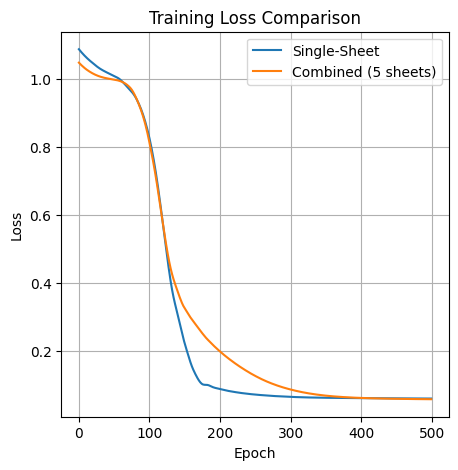

In [129]:
# Side by side training curves comparison
plt.figure(figsize=(5, 5))
min_epochs = min(len(train_losses), len(combined_losses))
plt.plot(train_losses[:min_epochs], label='Single-Sheet')
plt.plot(combined_losses[:min_epochs], label='Combined (5 sheets)')
plt.title('Training Loss Comparison')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.show()